# Programming Assignment \#2, Deliverable 6
## Eren Akgunduz

In [1]:
import os
import sys
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score

### Logger

The logging system **definitely** came in handy when I was testing my code in the Python script. Although it *does* also work within this notebook, I feel that it's unnecessary and creates clutter for the outputs. In the interest of displaying only the necessary plots and info, I changed the logging level here to warnings only (to keep it quiet).

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

fh = logging.StreamHandler()
fmt = logging.Formatter(
    "%(asctime)s %(levelname)s %(lineno)d:%(filename)s(%(process)d) - %(message)s"
)
fh.setFormatter(fmt)
logger.addHandler(fh)

In [3]:
# --- all tuning parameters ---
l = np.logspace(-2, 6, 9)  # lambda, from 1e-2 to 1e6, and with nine total samples
a = np.linspace(0, 1, 6)  # alpha, from 0 to 1, now with six evenly spaced samples

### Functions

In [4]:
def preprocess_data(filename: str) -> tuple:
    "Take in raw data and convert it to a workable format/state"
    if not isinstance(filename, str):
        raise TypeError("Filename should be a string :)")

    try:
        datafile = f"{os.getcwd()}/{filename}"
        logger.debug(datafile)
        if not os.path.exists(datafile):
            raise OSError("Expected data file, didn't find it :/")

        df = pd.read_csv(datafile, sep=",")  # read and pass to dataframe
        # debug shows that scikit-learn has mapped male to 1 and female to 0
        df[["Gender", "Student", "Married"]] = OrdinalEncoder().fit_transform(
            df[["Gender", "Student", "Married"]]
        )
        logger.debug(df[["Gender", "Student", "Married"]].head(10))

        # convert dataframe to numpy array for faster computations
        return (df.columns.to_numpy(), np.array(df))
    except OSError:
        print("Couldn't load in the data due to OS error.")
        sys.exit("Check if things are right and try again :)")

In [5]:
def standardize(data) -> tuple:
    "Establish design matrix and response vector, prepare both for elastic net"
    y = data[:, 9]  # extract only the data from the output column (balance)
    y = (lambda c: c - c.mean())(y)  # IIFE to center response vector
    logger.debug(y.shape)
    logger.debug(y.mean())

    dm = np.delete(data, 9, axis=1)  # extract the design matrix
    X = StandardScaler().fit_transform(dm)  # standardize (center & scale)

    logger.debug(X.shape)
    logger.debug([np.mean(X[:, k]) for k in range(X.shape[1])])
    logger.debug([np.std(X[:, k]) for k in range(X.shape[1])])
    return (X, y)

In [6]:
def elastic_net(X, y, l, a, cv: bool = False, k: int = 5) -> np.ndarray:
    if not isinstance(k, int):
        raise TypeError("Number of folds should be an integer :)")

    coeffs = np.zeros((6, 9, 9))
    cv_errors = np.zeros((9, 6, 5))

    def en(l, a):
        elastic = ElasticNet(alpha=l, l1_ratio=a)
        elastic.fit(X, y)
        return elastic.coef_

    if not isinstance(l, (int, float)) and not isinstance(a, (int, float)):
        for i_a, val_a in enumerate(np.flip(a)):
            for i_l, val_l in enumerate(l):
                if cv:
                    cv_errors[i_l, i_a] = np.abs(
                        cross_val_score(
                            ElasticNet(alpha=val_l, l1_ratio=val_a),
                            X,
                            y,
                            cv=k,
                            scoring="neg_mean_squared_error",
                        )
                    )
                else:
                    coeffs[i_a, i_l] = en(val_l, val_a)
    else:
        coeffs = en(l, a)

    if cv:
        logger.debug(f"{cv_errors.shape}\n{cv_errors}")
        logger.debug(cv_errors.mean(axis=2))
        return cv_errors.mean(axis=2)
    return coeffs

In [7]:
columns, data = preprocess_data("Credit_N400_p9.csv")  # unpack the tuple

### Deliverable \#1

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.461e+06, tolerance: 8.434e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.295e+06, tolerance: 8.434e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

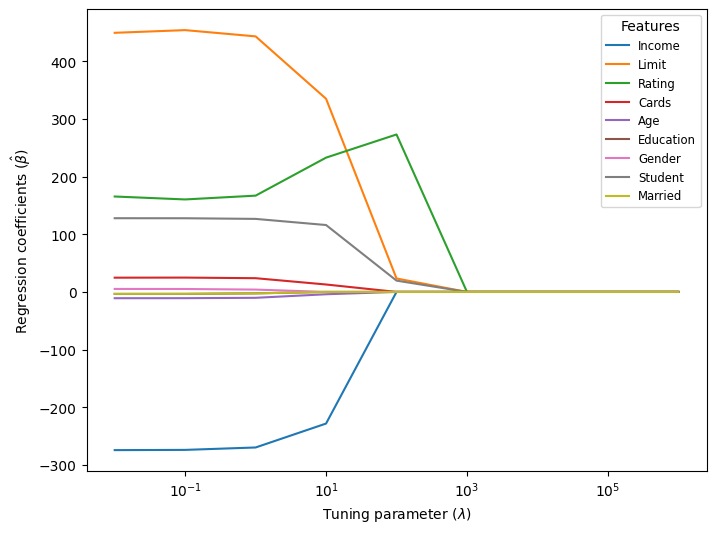

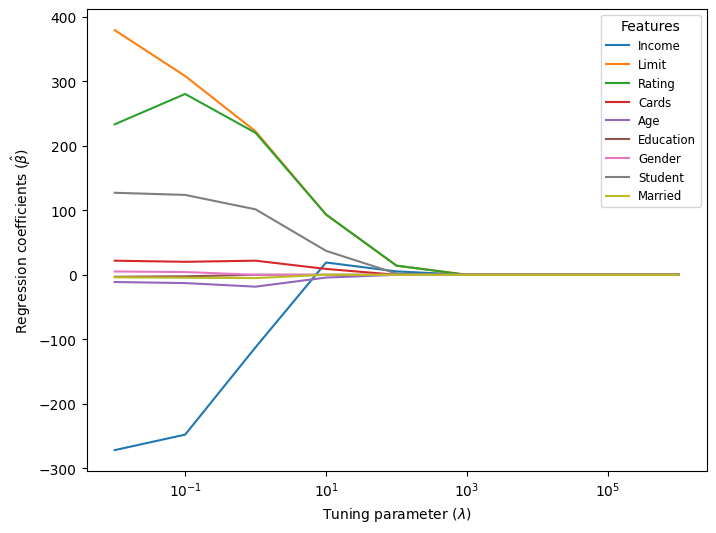

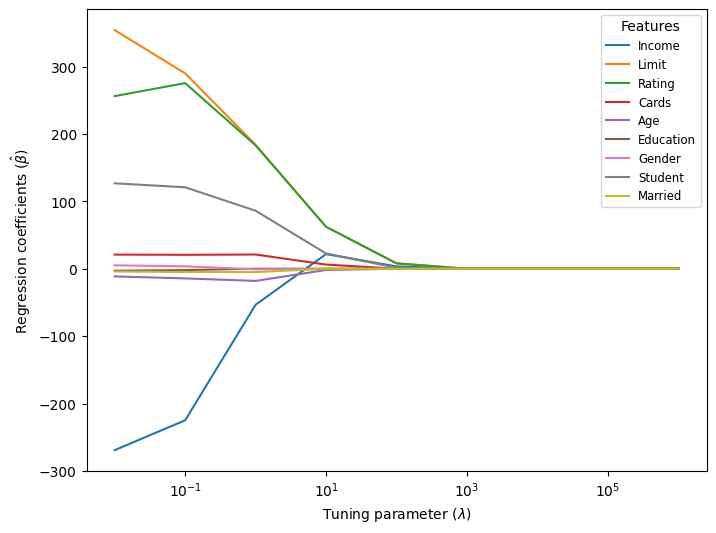

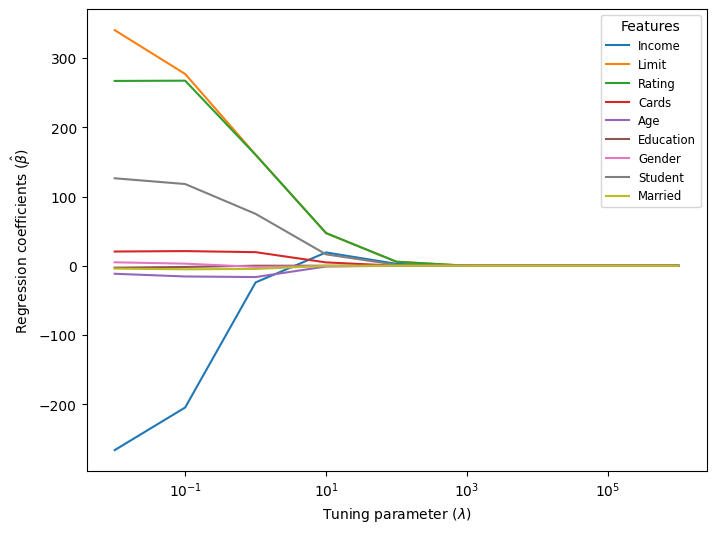

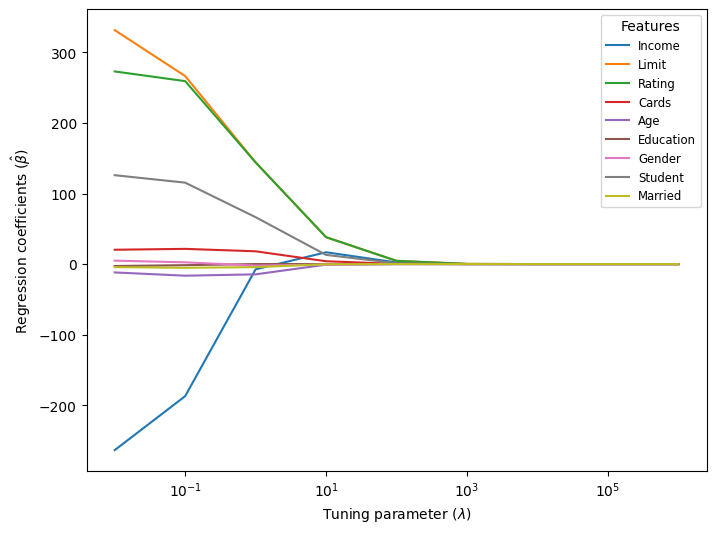

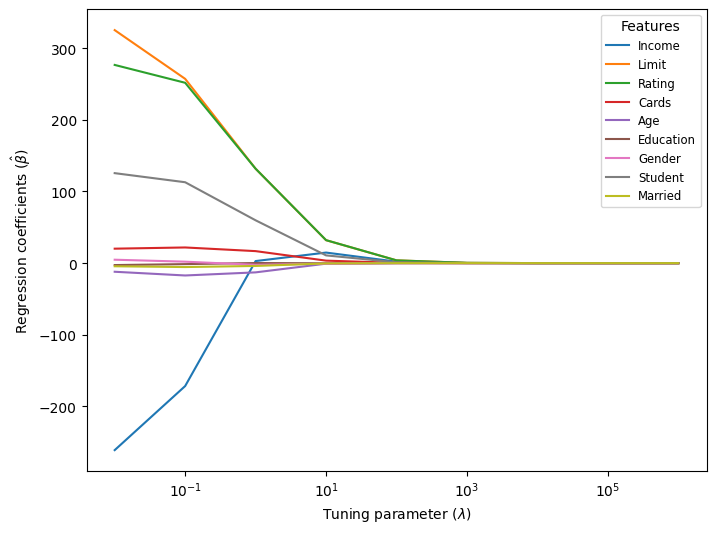

In [8]:
X, y = standardize(data)
B = elastic_net(X, y, l, a)
logger.debug(f"{B.shape}\n{B}")
for index, alpha in enumerate(B):
    plt.figure(figsize=(8, 6))
    plt.xscale("log")
    # transpose so that each row is one of the nine features with the nine columns for TP
    # this way, each index (row) has the vector I need to plot points
    [plt.plot(l, b, label=f"{columns[i]}") for i, b in enumerate(alpha.T)]
    plt.xlabel(r"Tuning parameter ($\lambda$)")
    plt.ylabel(r"Regression coefficients ($\hat{\beta}$)")
    plt.legend(title="Features", fontsize="small")
    plt.show()

### Deliverable \#2

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.030e+06, tolerance: 6.885e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e+06, tolerance: 6.427e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

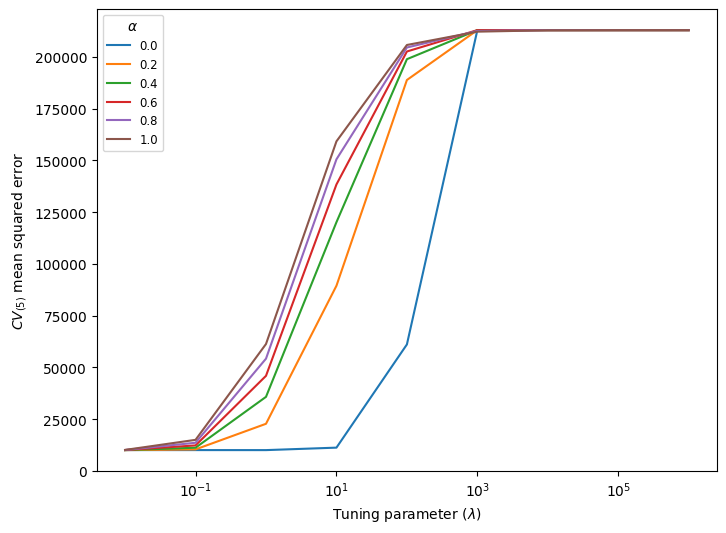

In [9]:
cv_error = elastic_net(X, y, l, a, True)
plt.figure(figsize=(8, 6))
plt.xscale("log")
[plt.plot(l, cv, label=f"{round(a[i], 1)}") for i, cv in enumerate(cv_error.T)]
plt.xlabel(r"Tuning parameter ($\lambda$)")
plt.ylabel(r"$CV_{(5)}$ mean squared error")
plt.legend(title=r"$\alpha$", fontsize="small")
plt.show()

### Deliverable \#3

In [10]:
logger.debug(cv_error.argmin())
logger.debug(cv_error.min())
logger.debug(
    cv_error[
        cv_error.argmin() // cv_error.shape[1],  # gets the row
        cv_error.argmin() % cv_error.shape[1],  # gets the column
    ]
)
l_optimal = float(l[cv_error.argmin() // cv_error.shape[1]])
a_optimal = float(a[cv_error.argmin() % cv_error.shape[1]])

In [11]:
l_optimal

0.01

In [12]:
a_optimal

0.2

### Deliverable \#4

In [13]:
B = elastic_net(X, y, l_optimal, a_optimal)

In [14]:
B

array([-263.6936746 ,  331.58058642,  273.0265893 ,   20.30004726,
        -11.84247466,   -2.75784286,    4.8565472 ,  125.96395948,
         -4.30969327])

In [15]:
B = elastic_net(X, y, l_optimal, a[0])  # lasso

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.461e+06, tolerance: 8.434e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [16]:
B

array([-261.02036531,  325.25679816,  276.66373364,   20.18590645,
        -12.03619677,   -2.69603511,    4.77503356,  125.61122885,
         -4.38078764])

In [17]:
B = elastic_net(X, y, l_optimal, a[5])  # ridge

In [18]:
B

array([-274.59721893,  449.77726422,  165.62279188,   24.74041056,
        -10.92080127,   -3.49462473,    5.18902879,  127.95769373,
         -3.37856026])

From main notebook:

> Considering that the shrinkage/penalty/regularization applied in all three training instances was relatively little, owing to the small value of the optimal $\lambda$ tuning parameter shared by all of them, we can see that a consequence of this is how the regression coefficient estimates for each feature remain fairly similar — even when comparing between various different $\alpha$ values like we do above.

While the scikit-learn implementation of the elastic net naturally does appear to display many of the same characteristics as my original, the plots are still considerably different — most notably in how much earlier of a $\lambda$ parameter value (around $10^3$ as opposed to the original at $10^5$/$10^6$) at which the coefficients (and as a result the MSEs) converge. This is primarily due to the differences in how the [cost function](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), as well as the coordinate descent algorithm to an extent, are implemented.